<a href="https://colab.research.google.com/github/FikretZajmovic/senior-design-project/blob/results-update/Sleep_Disorder_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from google.colab import drive
drive.mount('/content/drive')

download_file_link = "https://drive.google.com/file/d/18VUJtZQzxc5xYUKMln6URL4z8CyXOW5S/view?usp=sharing"

df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep

In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df = df.dropna()

In [ ]:
label_encoders = {}

In [ ]:
label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])  # Male=1, Female=0

In [ ]:
label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])

In [ ]:
label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])  # Sleep Disorder: None=0, Insomnia=1, Sleep Apnea=2

In [ ]:
df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True)

df["Systolic_BP"] = pd.to_numeric(df["Systolic_BP"])
df["Diastolic_BP"] = pd.to_numeric(df["Diastolic_BP"])

df = df.drop(columns=["Blood Pressure"])

In [ ]:
features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category",
            "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]
columns_order = ["Person ID", "Age", "Gender", "Occupation", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category",
            "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps", "Sleep Disorder"]
df = df[columns_order]

In [ ]:
X = df[features]
y = df["Sleep Disorder"]

In [ ]:
scaler = StandardScaler()
X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
   "Stress Level", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]] = scaler.fit_transform(
    X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
       "Stress Level", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]])

<ipython-input-11-8e130f7d6be2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (124, 11), Testing set: (31, 11)


**updates**

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, train_test_split, cross_validate
)
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, roc_auc_score,
    classification_report
)

# 1. Mount & load
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

# 2. Split Blood Pressure into numeric columns & drop original
df[["Systolic_BP","Diastolic_BP"]] = (
    df["Blood Pressure"].str.split("/", expand=True).astype(float)
)
df.drop(columns=["Blood Pressure"], inplace=True)

# 3. Fill missing target rows with “No Disorder”
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("No Disorder")

# 4. Label‐encode categorical columns
label_encoders = {}
for col in ["Gender","BMI Category","Sleep Disorder"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 5. Define features and target
numeric_feats     = [
    "Age", "Sleep Duration", "Quality of Sleep",
    "Physical Activity Level", "Stress Level",
    "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"
]
categorical_feats = ["Gender", "BMI Category", "Occupation"]

X = df[numeric_feats + categorical_feats]
y = df["Sleep Disorder"]

# 6. Build preprocessing pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("nums", num_pipe, numeric_feats),
    ("cats", cat_pipe, categorical_feats)
])

# 7. Assemble full RandomForest pipeline
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf",     RandomForestClassifier(
                   class_weight="balanced",
                   random_state=42
               ))
])

# 8. Define hyperparameter grid
param_grid = {
    "clf__max_depth":    [None, 10, 20],
    "clf__n_estimators": [100, 200, 400]
}

# 9. Nested CV with multiple metrics
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

inner_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1
)

scoring = {
    "accuracy":      "accuracy",
    "precision":     "precision_macro",
    "f1":            "f1_macro",
    "roc_auc":       "roc_auc_ovr"
}

nested_results = cross_validate(
    inner_search,
    X, y,
    cv=outer_cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

for metric in scoring:
    scores = nested_results[f"test_{metric}"]
    print(f"Nested CV {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

# 10. Final hold-out evaluation (20% test split)
inner_search.fit(X, y)
best_model = inner_search.best_estimator_

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
y_pred       = best_model.predict(X_te)
y_pred_proba = best_model.predict_proba(X_te)

# Binarize for multiclass ROC AUC
classes = list(range(len(label_encoders["Sleep Disorder"].classes_)))
y_te_bin = label_binarize(y_te, classes=classes)

acc     = accuracy_score(y_te, y_pred)
prec    = precision_score(y_te, y_pred, average="macro")
f1m     = f1_score(y_te, y_pred, average="macro")
rocauc  = roc_auc_score(y_te_bin, y_pred_proba, multi_class="ovr", average="macro")

print("\nFinal hold-out metrics:")
print(f" Accuracy : {acc:.3f}")
print(f" Precision: {prec:.3f}")
print(f" F1-score : {f1m:.3f}")
print(f" ROC AUC  : {rocauc:.3f}")

print("\nClassification Report:")
print(classification_report(
    y_te,
    y_pred,
    target_names=label_encoders["Sleep Disorder"].classes_
))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Nested CV accuracy: 0.882 ± 0.020
Nested CV precision: 0.861 ± 0.031
Nested CV f1: 0.861 ± 0.024
Nested CV roc_auc: 0.928 ± 0.031

Final hold-out metrics:
 Accuracy : 1.000
 Precision: 1.000
 F1-score : 1.000
 ROC AUC  : 1.000

Classification Report:
              precision    recall  f1-score   support

    Insomnia       1.00      1.00      1.00        15
 No Disorder       1.00      1.00      1.00        44
 Sleep Apnea       1.00      1.00      1.00        16

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

# sklearn & imblearn
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_validate
)
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, roc_auc_score, classification_report
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. Mount & load
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

# 2. Split BP → numeric, fill target
df[["Systolic_BP","Diastolic_BP"]] = (
    df["Blood Pressure"].str.split("/", expand=True).astype(float)
)
df.drop(columns=["Blood Pressure"], inplace=True)
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("No Disorder")

# 3. Label-encode
les = {}
for col in ["Gender","BMI Category","Sleep Disorder"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    les[col] = le

# 4. Feature / target
numeric_feats     = [
    "Age","Sleep Duration","Quality of Sleep","Physical Activity Level","Stress Level",
    "Systolic_BP","Diastolic_BP","Heart Rate","Daily Steps"
]
categorical_feats = ["Gender","BMI Category","Occupation"]
X = df[numeric_feats + categorical_feats]
y = df["Sleep Disorder"]

# 5. Preprocessing
num_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
cat_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh",     OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("nums", num_pipe, numeric_feats),
    ("cats", cat_pipe, categorical_feats)
])

# 6. SMOTE + XGBoost pipeline (preproc → SMOTE → classifier)
pipeline = ImbPipeline([
    ("preproc",  preprocessor),
    ("smote",    SMOTE(random_state=42)),
    ("clf",      XGBClassifier(
                     objective="multi:softprob",
                     eval_metric="mlogloss",
                     use_label_encoder=False,
                     random_state=42
                ))
])

# 7. Hyperparameter grid
param_grid = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth":    [3, 6, 10],
    "clf__learning_rate":[0.01, 0.1, 0.2],
    "clf__subsample":    [0.7, 1.0]
}

# 8. Nested CV
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

scoring = {
    "accuracy":  "accuracy",
    "precision": "precision_macro",
    "f1":        "f1_macro",
    "roc_auc":   "roc_auc_ovr"
}

nested = cross_validate(
    grid,
    X, y,
    cv=outer_cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

print("=== Nested CV Performance ===")
for metric, name in scoring.items():
    scores = nested[f"test_{metric}"]
    print(f"{name:10s}: {scores.mean():.3f} ± {scores.std():.3f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


=== Nested CV Performance ===
accuracy  : 0.909 ± 0.020
precision_macro: 0.893 ± 0.019
f1_macro  : 0.881 ± 0.022
roc_auc_ovr: 0.928 ± 0.025


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


FINAL RESULTS

In [ ]:
# 0. If you haven’t yet, install scikeras
#!pip install scikeras

import pandas as pd
import numpy as np
from google.colab import drive

# sklearn & friends
from sklearn.preprocessing     import LabelEncoder, label_binarize
from sklearn.pipeline          import Pipeline as SKPipeline
from sklearn.compose           import ColumnTransformer
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import StandardScaler, OneHotEncoder
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier
from sklearn.svm               import SVC
from xgboost                   import XGBClassifier
from imblearn.pipeline         import Pipeline as ImbPipeline
from imblearn.over_sampling    import SMOTE
from sklearn.model_selection   import (
    StratifiedKFold, GridSearchCV, cross_validate, train_test_split
)
from sklearn.metrics           import (
    accuracy_score, precision_score, f1_score, roc_auc_score, classification_report
)

# scikeras for ANN
from scikeras.wrappers         import KerasClassifier
from tensorflow.keras.models   import Sequential
from tensorflow.keras.layers   import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

# 1) Load & preprocess dataframe
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

# Split BP → numeric, fill target
df[["Systolic_BP","Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df.drop(columns=["Blood Pressure"], inplace=True)
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("No Disorder")

# Label-encode
les = {}
for col in ["Gender","BMI Category","Sleep Disorder"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    les[col] = le

# Features & target
numeric_feats     = [
    "Age","Sleep Duration","Quality of Sleep","Physical Activity Level","Stress Level",
    "Systolic_BP","Diastolic_BP","Heart Rate","Daily Steps"
]
categorical_feats = ["Gender","BMI Category","Occupation"]
X = df[numeric_feats + categorical_feats]
y = df["Sleep Disorder"]

# 2) Preprocessor
num_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
cat_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh",     OneHotEncoder(handle_unknown="ignore"))
])
preproc = ColumnTransformer([
    ("nums", num_pipe, numeric_feats),
    ("cats", cat_pipe, categorical_feats)
])

# 3) Define models & param grids (excluding ANN)
models = {
    "LogisticRegression": (
        LogisticRegression(class_weight="balanced", max_iter=1000),
        {"clf__C":[0.01,0.1,1,10]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {"clf__n_estimators":[200,400], "clf__max_depth":[None,10,20]}
    ),
    "XGBoost": (
        XGBClassifier(objective="multi:softprob", use_label_encoder=False,
                      eval_metric="mlogloss", random_state=42),
        {"clf__n_estimators":[200,400], "clf__max_depth":[3,6,10], "clf__learning_rate":[0.05,0.1]}
    ),
    "SVM": (
        SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
        {"clf__C":[0.1,1,10], "clf__gamma":['scale','auto']}
    )
}

# 4) Nested CV setup for non-ANN
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = {
    "accuracy":  "accuracy",
    "precision": "precision_macro",
    "f1":        "f1_macro",
    "roc_auc":   "roc_auc_ovr"
}

results = {}
for name, (est, params) in models.items():
    print(f"\n▶️  Nested CV on {name}...")
    pipe   = ImbPipeline([("preproc", preproc), ("smote", SMOTE(random_state=42)), ("clf", est)])
    search = GridSearchCV(pipe, params, cv=inner_cv, scoring="f1_macro", n_jobs=-1)
    res = cross_validate(search, X, y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    metrics = {m: (res[f"test_{m}"].mean(), res[f"test_{m}"].std()) for m in scoring}
    results[name] = metrics
    for m,(mu,s) in metrics.items():
        print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

# 5) Manual ANN implementation with cross-validation
def create_ann_model(input_dim, n_classes):
    """Create ANN model with specified architecture"""
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Manual cross-validation for ANN
print("\n▶️  5-fold CV on ANN (manual implementation)...")

ann_scores = {metric: [] for metric in scoring.keys()}

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X, y)):
    print(f"   Fold {fold + 1}/5...")

    # Split data
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocess
    X_train_processed = preproc.fit_transform(X_train_fold)
    X_val_processed = preproc.transform(X_val_fold)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_fold)

    # Create and train model
    model = create_ann_model(X_train_balanced.shape[1], len(np.unique(y)))

    # Train with early stopping
    model.fit(
        X_train_balanced, y_train_balanced,
        epochs=50,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )

    # Predict
    y_pred = model.predict(X_val_processed, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate metrics
    ann_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred_classes))
    ann_scores['precision'].append(precision_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))
    ann_scores['f1'].append(f1_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))

    # For ROC-AUC, we need probability predictions
    try:
        if len(np.unique(y)) == 2:  # Binary classification
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred[:, 1]))
        else:  # Multi-class
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred, multi_class='ovr'))
    except:
        ann_scores['roc_auc'].append(0.0)

# Calculate means and stds
ann_metrics = {}
for metric in scoring.keys():
    scores = np.array(ann_scores[metric])
    ann_metrics[metric] = (scores.mean(), scores.std())

results["ANN"] = ann_metrics
for m, (mu, s) in ann_metrics.items():
    print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

# 6) Summary
print("\n\n=== Summary of Nested CV Performance ===")
for name,metrics in results.items():
    print(f"\n{name}:")
    for m,(mu,s) in metrics.items():
        print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

▶️  Nested CV on LogisticRegression...
   accuracy : 0.898 ± 0.022
   precision: 0.877 ± 0.021
   f1       : 0.872 ± 0.023
   roc_auc  : 0.920 ± 0.037

▶️  Nested CV on RandomForest...
   accuracy : 0.912 ± 0.023
   precision: 0.901 ± 0.023
   f1       : 0.890 ± 0.023
   roc_auc  : 0.926 ± 0.031

▶️  Nested CV on XGBoost...
   accuracy : 0.917 ± 0.018
   precision: 0.905 ± 0.016
   f1       : 0.895 ± 0.017
   roc_auc  : 0.922 ± 0.025

▶️  Nested CV on SVM...
   accuracy : 0.906 ± 0.025
   precision: 0.893 ± 0.029
   f1       : 0.888 ± 0.029
   roc_auc  : 0.933 ± 0.030

▶️  5-fold CV on ANN (manual implementation)...
   Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 2/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 3/5...
   Fold 4/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Fold 5/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   accuracy : 0.917 ± 0.026
   precision: 0.905 ± 0.026
   f1       : 0.898 ± 0.026
   roc_auc  : 0.928 ± 0.030


=== Summary of Nested CV Performance ===

LogisticRegression:
   accuracy : 0.898 ± 0.022
   precision: 0.877 ± 0.021
   f1       : 0.872 ± 0.023
   roc_auc  : 0.920 ± 0.037

RandomForest:
   accuracy : 0.912 ± 0.023
   precision: 0.901 ± 0.023
   f1       : 0.890 ± 0.023
   roc_auc  : 0.926 ± 0.031

XGBoost:
   accuracy : 0.917 ± 0.018
   precision: 0.905 ± 0.016
   f1       : 0.895 ± 0.017
   roc_auc  : 0.922 ± 0.025

SVM:
   accuracy : 0.906 ± 0.025
   precision: 0.893 ± 0.029
   f1       : 0.888 ± 0.029
   roc_auc  : 0.933 ± 0.030

ANN:
   accuracy : 0.917 ± 0.026
   precision: 0.905 ± 0.026
   f1       : 0.898 ± 0.026
   roc_auc  : 0.928 ± 0.030


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Dataset Overview:
Shape: (374, 13)
Features: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

🔍 Creating Exploratory Data Analysis Plots...


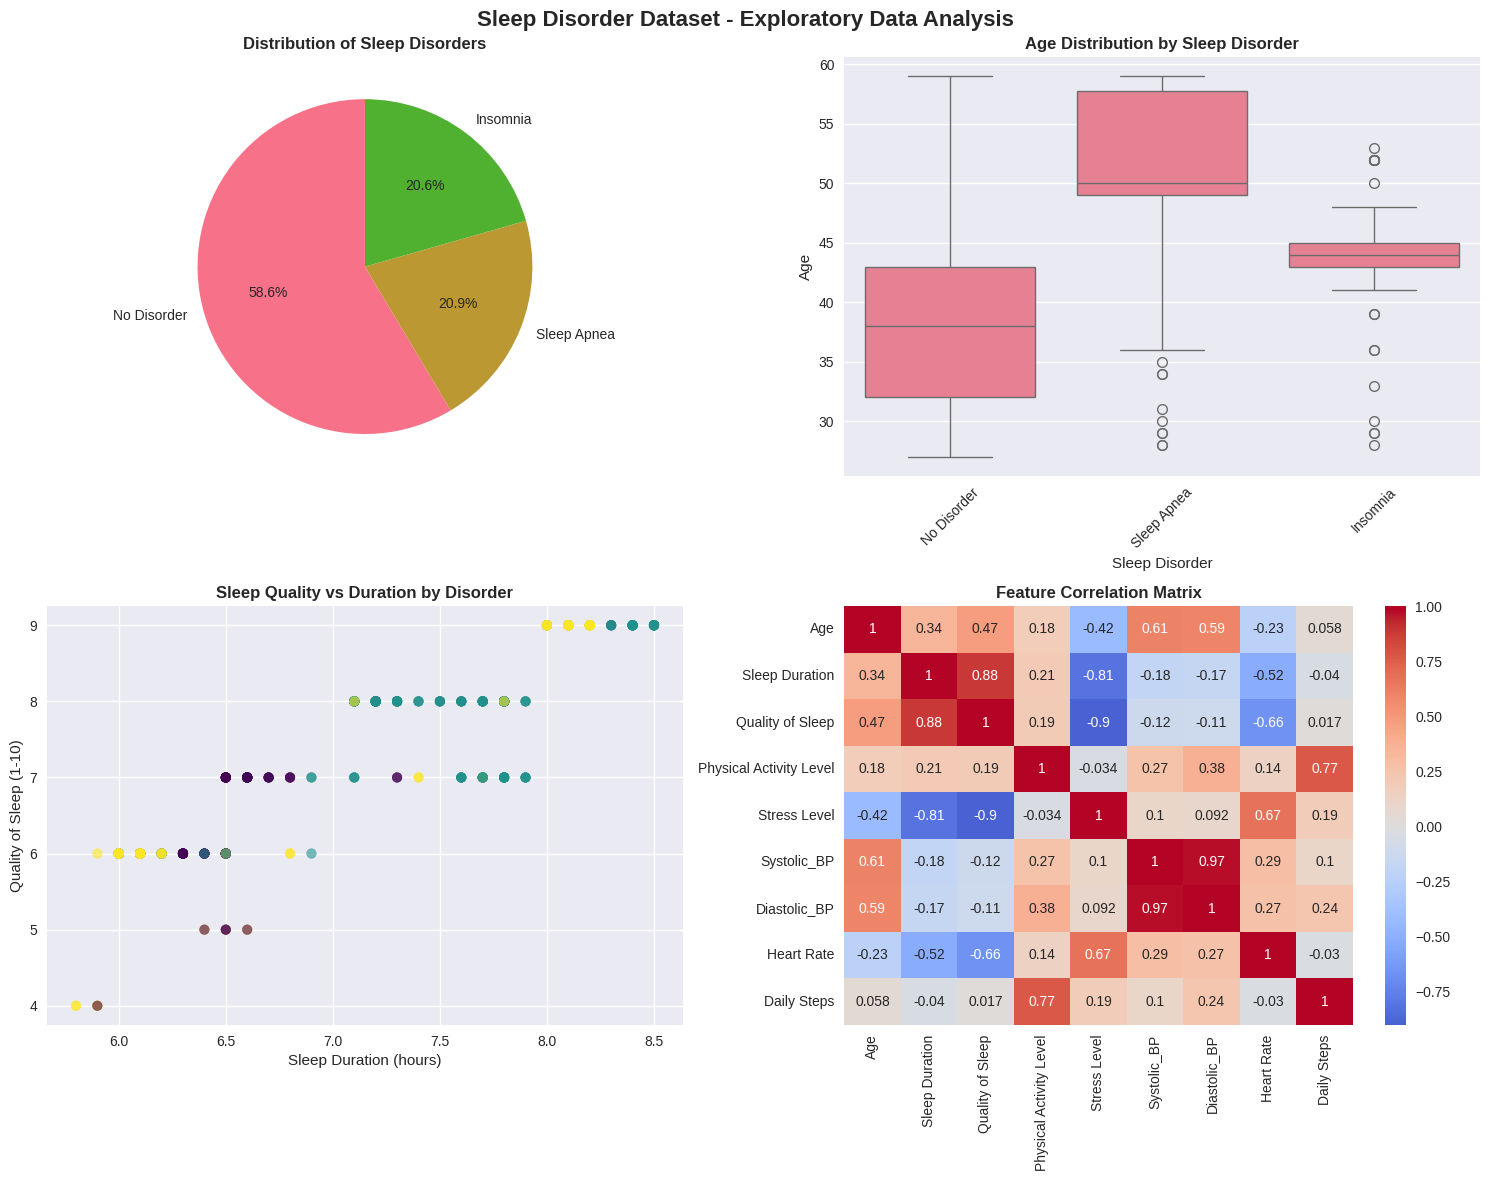


🚀 Running Machine Learning Experiments...

▶️  Nested CV on Logistic Regression...
   accuracy : 0.898 ± 0.022
   precision: 0.877 ± 0.021
   f1       : 0.872 ± 0.023
   roc_auc  : 0.920 ± 0.037

▶️  Nested CV on Random Forest...
   accuracy : 0.912 ± 0.023
   precision: 0.901 ± 0.023
   f1       : 0.890 ± 0.023
   roc_auc  : 0.926 ± 0.031

▶️  Nested CV on XGBoost...
   accuracy : 0.917 ± 0.018
   precision: 0.905 ± 0.016
   f1       : 0.895 ± 0.017
   roc_auc  : 0.922 ± 0.025

▶️  Nested CV on SVM...
   accuracy : 0.906 ± 0.025
   precision: 0.893 ± 0.029
   f1       : 0.888 ± 0.029
   roc_auc  : 0.933 ± 0.030

▶️  5-fold CV on ANN (manual implementation)...
   Fold 1/5...
   Fold 2/5...
   Fold 3/5...
   Fold 4/5...
   Fold 5/5...
   accuracy : 0.917 ± 0.026
   precision: 0.905 ± 0.026
   f1       : 0.898 ± 0.026
   roc_auc  : 0.929 ± 0.030

🎨 Creating Comprehensive Visualizations...


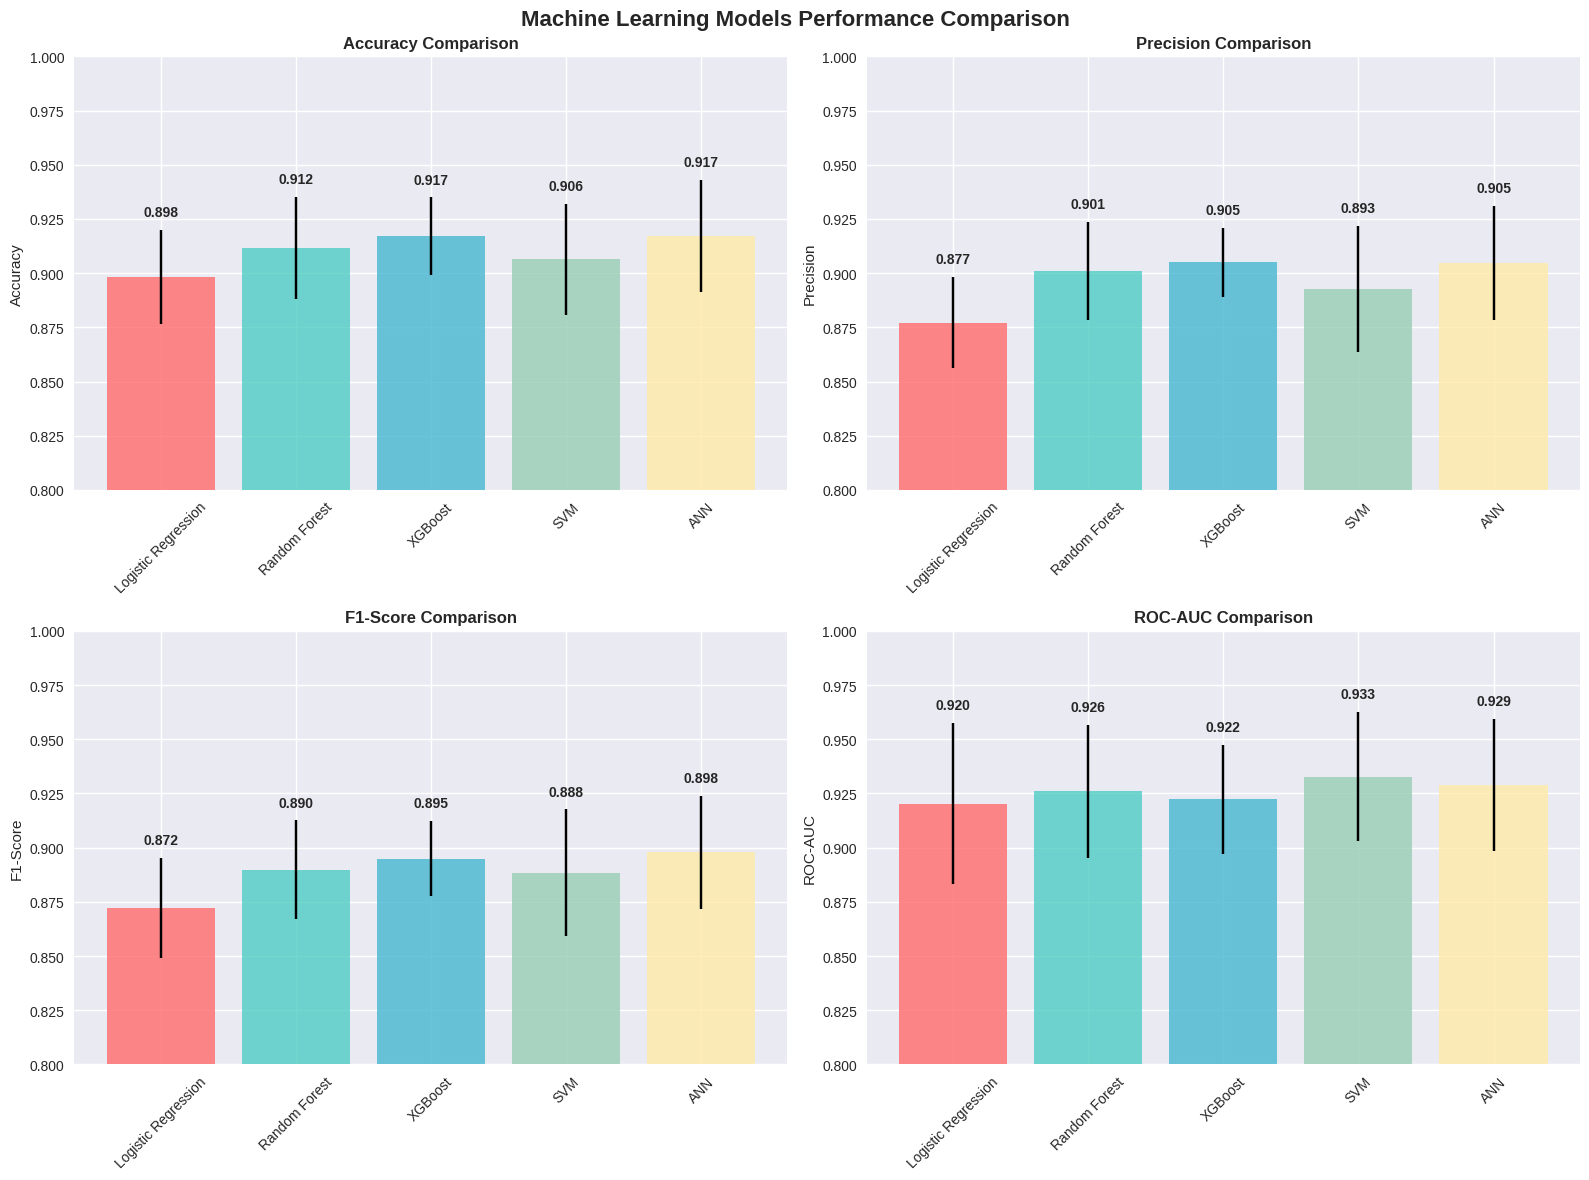

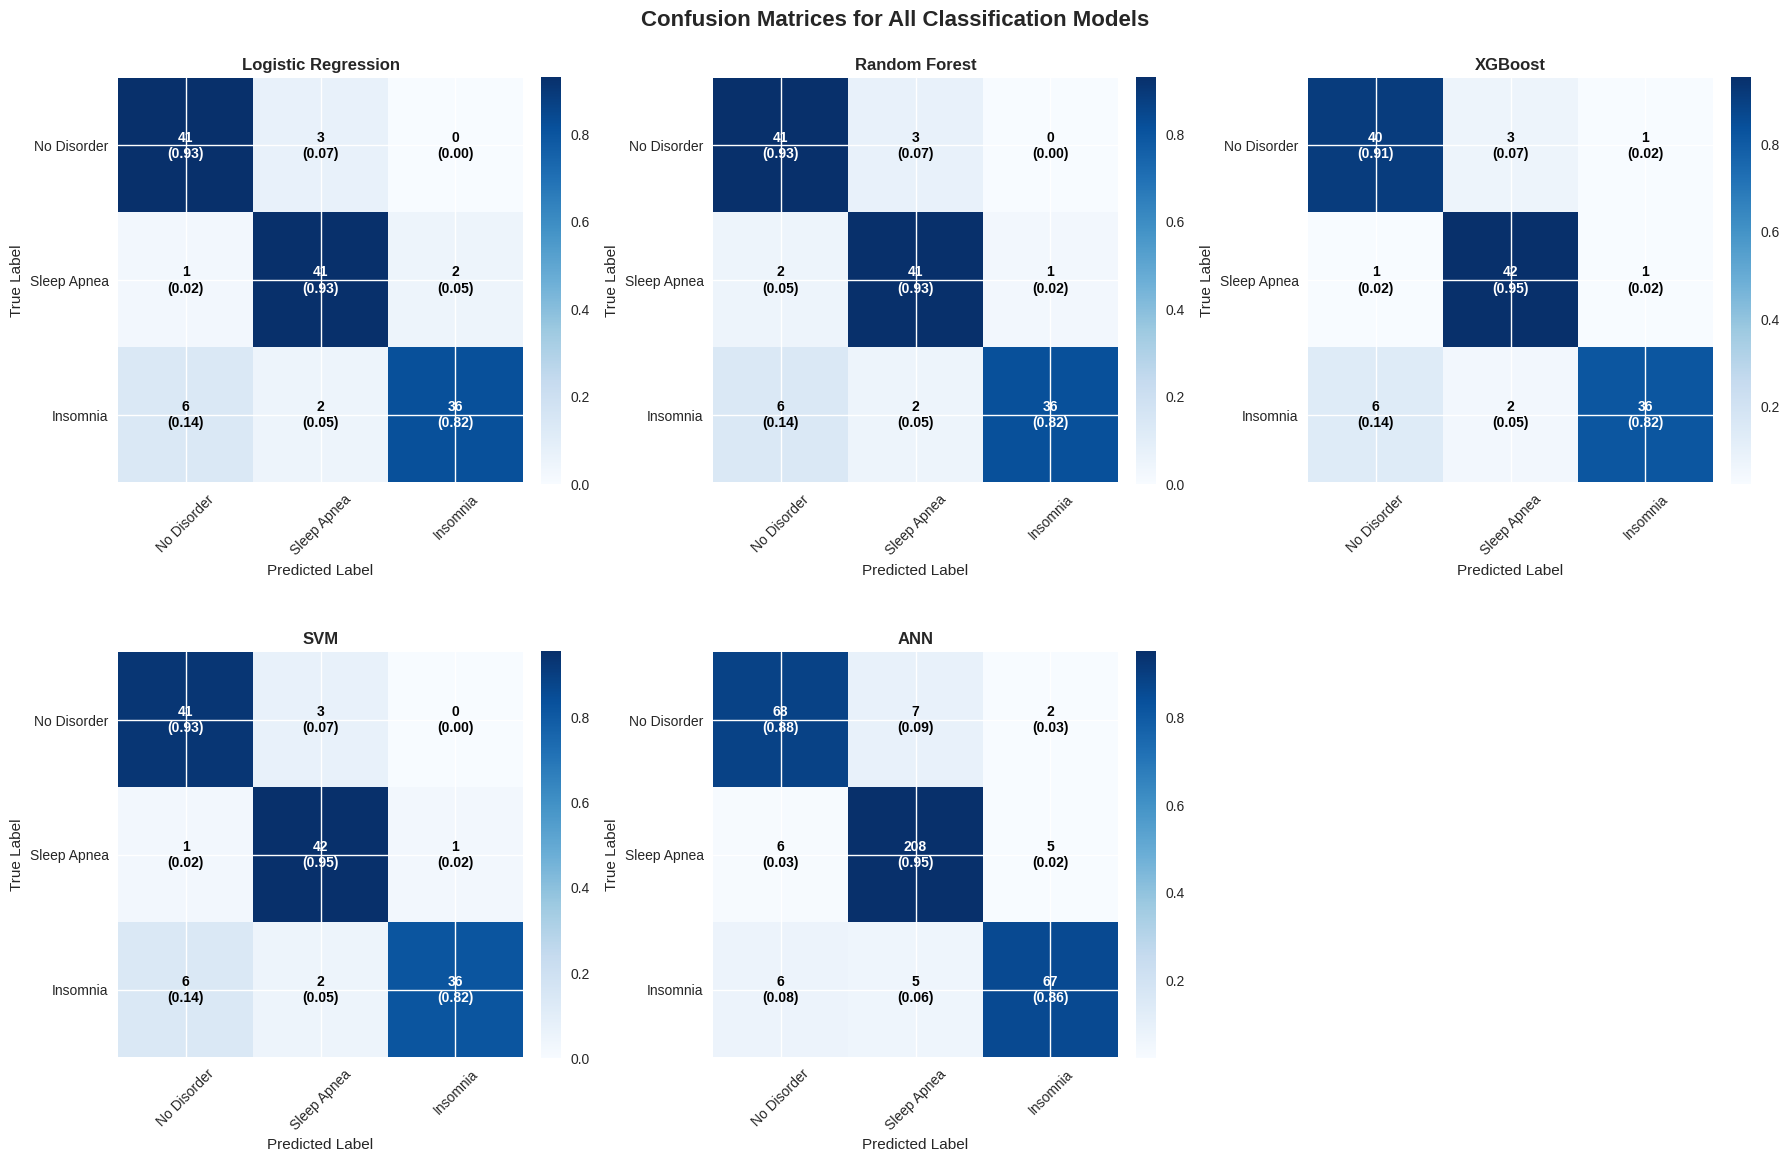

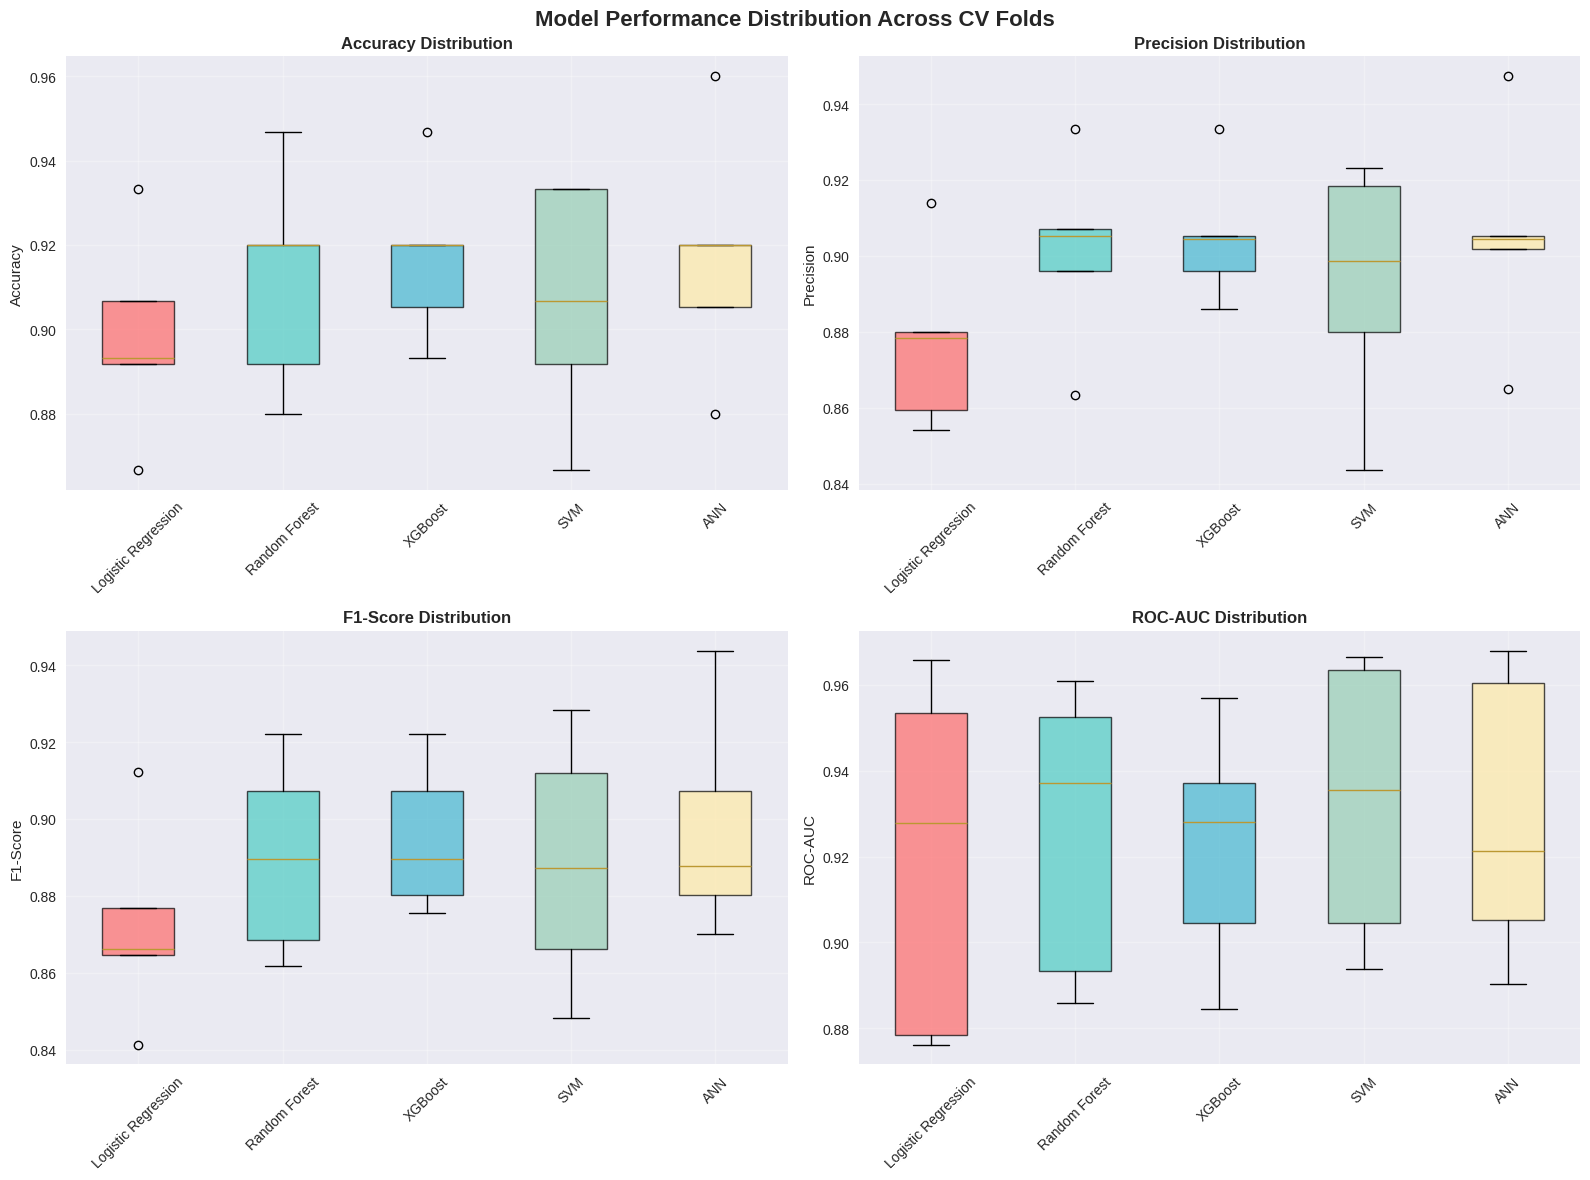

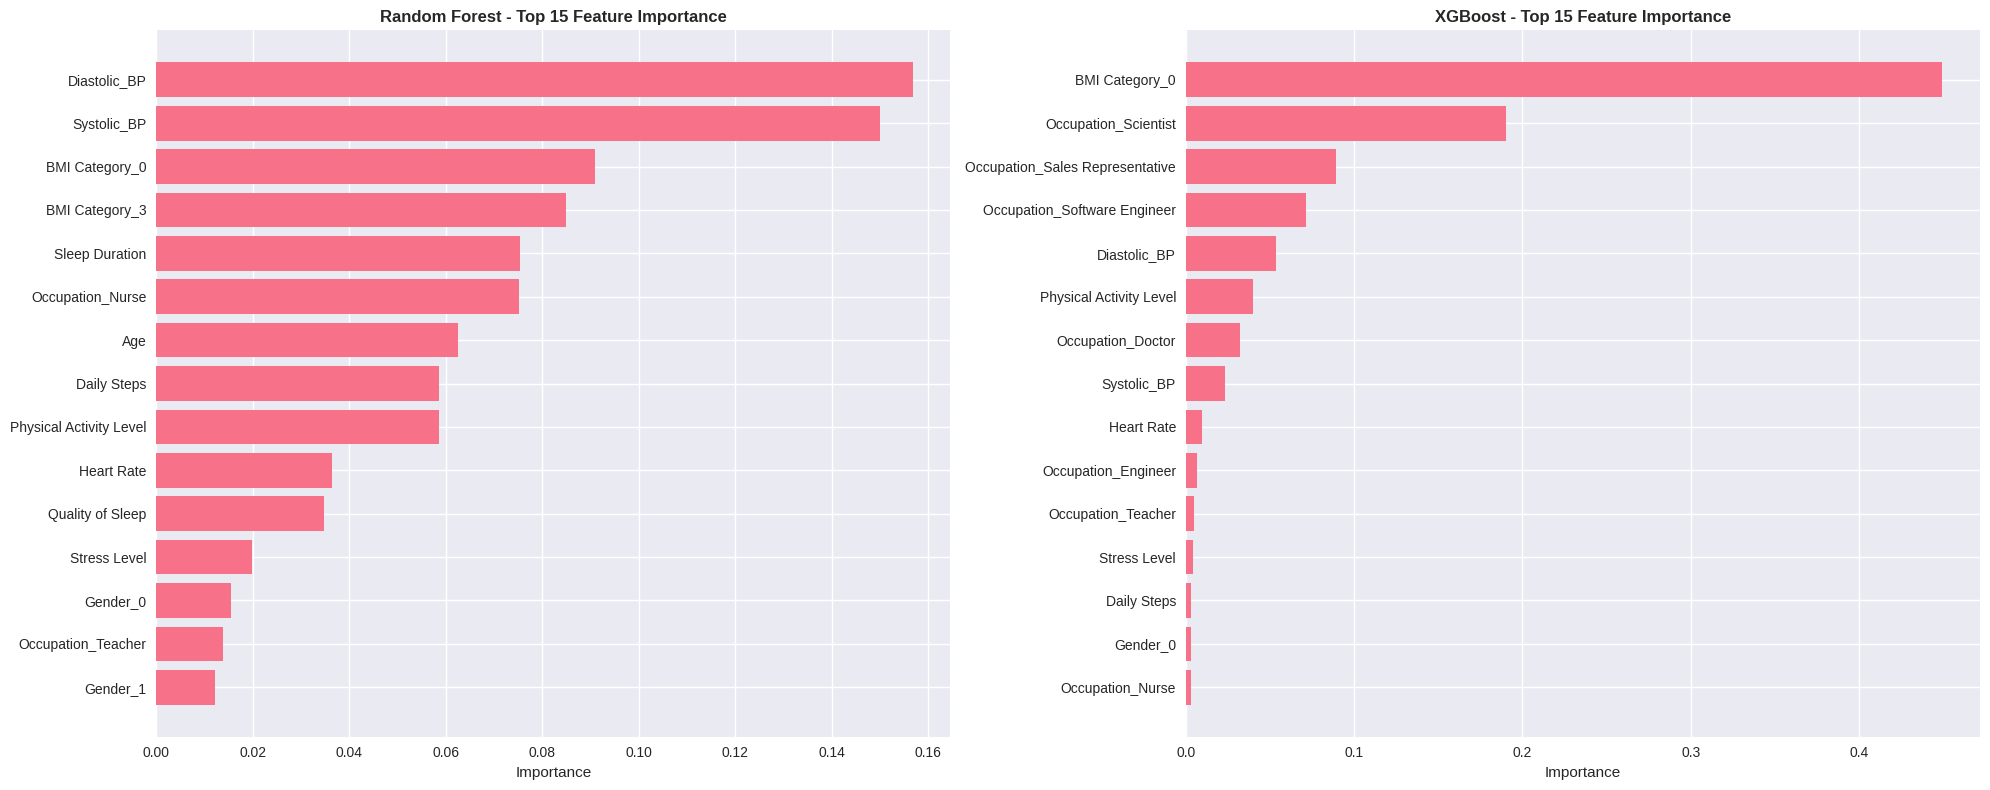


📊 FINAL RESULTS SUMMARY
                    Accuracy (Mean±Std) Precision (Mean±Std) F1-Score (Mean±Std) ROC-AUC (Mean±Std)
Logistic Regression       0.898 ± 0.022        0.877 ± 0.021       0.872 ± 0.023      0.920 ± 0.037
Random Forest             0.912 ± 0.023        0.901 ± 0.023       0.890 ± 0.023      0.926 ± 0.031
XGBoost                   0.917 ± 0.018        0.905 ± 0.016       0.895 ± 0.017      0.922 ± 0.025
SVM                       0.906 ± 0.025        0.893 ± 0.029       0.888 ± 0.029      0.933 ± 0.030
ANN                       0.917 ± 0.026        0.905 ± 0.026       0.898 ± 0.026      0.929 ± 0.030

🏆 BEST PERFORMING MODEL: ANN
📊 F1-Score: 0.898 ± 0.026
🎯 Accuracy: 0.917 ± 0.026

✅ All visualizations completed successfully!
📈 Your senior design project now has comprehensive visual analysis!


In [6]:
# Enhanced Sleep Disorder Prediction with Comprehensive Visualizations
# 0. Install required packages if needed
# !pip install seaborn plotly

import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# sklearn & friends
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_validate, train_test_split
)
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, auc
)

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

# 1) Load & preprocess dataframe
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Features: {list(df.columns)}")

# Split BP → numeric, fill target
df[["Systolic_BP","Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df.drop(columns=["Blood Pressure"], inplace=True)
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("No Disorder")

# Exploratory Data Analysis Plots
print("\n🔍 Creating Exploratory Data Analysis Plots...")

# Plot 1: Target Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Sleep Disorder Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Target distribution
target_counts = df["Sleep Disorder"].value_counts()
axes[0,0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribution of Sleep Disorders', fontweight='bold')

# Age distribution by disorder
sns.boxplot(data=df, x="Sleep Disorder", y="Age", ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Sleep Disorder', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)

# Sleep quality vs duration
scatter = axes[1,0].scatter(df["Sleep Duration"], df["Quality of Sleep"],
                           c=df["Sleep Disorder"].astype('category').cat.codes,
                           alpha=0.6, cmap='viridis')
axes[1,0].set_xlabel('Sleep Duration (hours)')
axes[1,0].set_ylabel('Quality of Sleep (1-10)')
axes[1,0].set_title('Sleep Quality vs Duration by Disorder', fontweight='bold')

# Correlation heatmap
numeric_cols = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
                "Stress Level", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.show()

# Label-encode
les = {}
for col in ["Gender","BMI Category","Sleep Disorder"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    les[col] = le

# Features & target
numeric_feats = [
    "Age","Sleep Duration","Quality of Sleep","Physical Activity Level","Stress Level",
    "Systolic_BP","Diastolic_BP","Heart Rate","Daily Steps"
]
categorical_feats = ["Gender","BMI Category","Occupation"]
X = df[numeric_feats + categorical_feats]
y = df["Sleep Disorder"]

# 2) Preprocessor
num_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
cat_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh",     OneHotEncoder(handle_unknown="ignore"))
])
preproc = ColumnTransformer([
    ("nums", num_pipe, numeric_feats),
    ("cats", cat_pipe, categorical_feats)
])

# 3) Define models & param grids
models = {
    "Logistic Regression": (
        LogisticRegression(class_weight="balanced", max_iter=1000),
        {"clf__C":[0.01,0.1,1,10]}
    ),
    "Random Forest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {"clf__n_estimators":[200,400], "clf__max_depth":[None,10,20]}
    ),
    "XGBoost": (
        XGBClassifier(objective="multi:softprob", use_label_encoder=False,
                      eval_metric="mlogloss", random_state=42),
        {"clf__n_estimators":[200,400], "clf__max_depth":[3,6,10], "clf__learning_rate":[0.05,0.1]}
    ),
    "SVM": (
        SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
        {"clf__C":[0.1,1,10], "clf__gamma":['scale','auto']}
    )
}

# 4) Nested CV setup
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = {
    "accuracy":  "accuracy",
    "precision": "precision_macro",
    "f1":        "f1_macro",
    "roc_auc":   "roc_auc_ovr"
}

# Store detailed results for visualization
detailed_results = {}
confusion_matrices = {}
roc_data = {}

print("\n🚀 Running Machine Learning Experiments...")

results = {}
for name, (est, params) in models.items():
    print(f"\n▶️  Nested CV on {name}...")
    pipe = ImbPipeline([("preproc", preproc), ("smote", SMOTE(random_state=42)), ("clf", est)])
    search = GridSearchCV(pipe, params, cv=inner_cv, scoring="f1_macro", n_jobs=-1)
    res = cross_validate(search, X, y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    metrics = {m: (res[f"test_{m}"].mean(), res[f"test_{m}"].std()) for m in scoring}
    results[name] = metrics

    # Store detailed fold results
    detailed_results[name] = {metric: res[f"test_{metric}"] for metric in scoring}

    for m,(mu,s) in metrics.items():
        print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

    # Get confusion matrix for best model
    # Train on full dataset with best params for visualization
    search.fit(X, y)
    X_processed = preproc.fit_transform(X)
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_processed, y)

    # Split for confusion matrix
    X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    best_model = search.best_estimator_.named_steps['clf']
    best_model.fit(X_train_vis, y_train_vis)
    y_pred = best_model.predict(X_test_vis)
    y_pred_proba = best_model.predict_proba(X_test_vis)

    confusion_matrices[name] = confusion_matrix(y_test_vis, y_pred)

    # Store ROC data for multiclass
    roc_data[name] = {
        'y_true': y_test_vis,
        'y_pred_proba': y_pred_proba,
        'classes': best_model.classes_
    }

# 5) ANN Implementation
def create_ann_model(input_dim, n_classes):
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

print("\n▶️  5-fold CV on ANN (manual implementation)...")

ann_scores = {metric: [] for metric in scoring.keys()}
ann_confusion_total = None

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X, y)):
    print(f"   Fold {fold + 1}/5...")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    X_train_processed = preproc.fit_transform(X_train_fold)
    X_val_processed = preproc.transform(X_val_fold)

    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_fold)

    model = create_ann_model(X_train_balanced.shape[1], len(np.unique(y)))

    model.fit(
        X_train_balanced, y_train_balanced,
        epochs=50,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )

    y_pred = model.predict(X_val_processed, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    ann_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred_classes))
    ann_scores['precision'].append(precision_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))
    ann_scores['f1'].append(f1_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))

    try:
        if len(np.unique(y)) == 2:
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred[:, 1]))
        else:
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred, multi_class='ovr'))
    except:
        ann_scores['roc_auc'].append(0.0)

    # Accumulate confusion matrix
    fold_cm = confusion_matrix(y_val_fold, y_pred_classes)
    if ann_confusion_total is None:
        ann_confusion_total = fold_cm
    else:
        ann_confusion_total += fold_cm

ann_metrics = {}
for metric in scoring.keys():
    scores = np.array(ann_scores[metric])
    ann_metrics[metric] = (scores.mean(), scores.std())

results["ANN"] = ann_metrics
detailed_results["ANN"] = {metric: np.array(ann_scores[metric]) for metric in scoring}
confusion_matrices["ANN"] = ann_confusion_total

for m, (mu, s) in ann_metrics.items():
    print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

# 6) CREATE COMPREHENSIVE VISUALIZATIONS
print("\n🎨 Creating Comprehensive Visualizations...")

# Plot 2: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Machine Learning Models Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'precision', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'F1-Score', 'ROC-AUC']

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx//2, idx%2]

    model_names = list(results.keys())
    means = [results[model][metric][0] for model in model_names]
    stds = [results[model][metric][1] for model in model_names]

    bars = ax.bar(model_names, means, yerr=stds, capsize=5, alpha=0.8,
                  color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    ax.set_title(f'{metric_name} Comparison', fontweight='bold')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0.8, 1.0)

    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 3: Confusion Matrices
n_models = len(confusion_matrices)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Classification Models', fontsize=16, fontweight='bold')

# Get class names
class_names = ['No Disorder', 'Sleep Apnea', 'Insomnia']  # Adjust based on your data

for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    ax.set_title(f'{model_name}', fontweight='bold')

    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                   ha="center", va="center",
                   color="white" if cm_normalized[i, j] > thresh else "black",
                   fontweight='bold')

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names[:cm.shape[1]], rotation=45)
    ax.set_yticklabels(class_names[:cm.shape[0]])

# Remove empty subplots
for idx in range(n_models, 6):
    row, col = idx // 3, idx % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Plot 4: Box Plot of Model Performance Across Folds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Distribution Across CV Folds', fontsize=16, fontweight='bold')

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx//2, idx%2]

    data_for_boxplot = []
    labels_for_boxplot = []

    for model_name in detailed_results.keys():
        data_for_boxplot.append(detailed_results[model_name][metric])
        labels_for_boxplot.append(model_name)

    bp = ax.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)

    # Customize box colors
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title(f'{metric_name} Distribution', fontweight='bold')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 5: Radar Chart for Model Comparison
def create_radar_chart():
    categories = ['Accuracy', 'Precision', 'F1-Score', 'ROC-AUC']
    metric_keys = ['accuracy', 'precision', 'f1', 'roc_auc']  # Correct keys

    fig = go.Figure()

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for idx, model_name in enumerate(results.keys()):
        values = [results[model_name][key][0] for key in metric_keys]
        values += [values[0]]  # Complete the circle

        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories + [categories[0]],
            fill='toself',
            name=model_name,
            line_color=colors[idx % len(colors)]
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0.8, 1.0]
            )),
        showlegend=True,
        title="Model Performance Radar Chart",
        title_x=0.5,
        font=dict(size=14)
    )

    fig.show()

try:
    create_radar_chart()
except Exception as e:
    print(f"Note: Radar chart requires plotly. Error: {e}")
    print("Continuing with other visualizations...")

# Plot 6: Feature Importance (for tree-based models)
def plot_feature_importance():
    # Get feature importance from Random Forest and XGBoost
    X_processed = preproc.fit_transform(X)
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_processed, y)

    # Random Forest
    rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=400)
    rf.fit(X_balanced, y_balanced)

    # XGBoost
    xgb = XGBClassifier(objective="multi:softprob", use_label_encoder=False,
                       eval_metric="mlogloss", random_state=42, n_estimators=400)
    xgb.fit(X_balanced, y_balanced)

    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, features in preproc.transformers_:
        if name == 'nums':
            feature_names.extend(features)
        else:  # categorical
            if hasattr(transformer.named_steps['oh'], 'get_feature_names_out'):
                cat_features = transformer.named_steps['oh'].get_feature_names_out(features)
                feature_names.extend(cat_features)

    # Plot feature importance
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Random Forest
    rf_importance = rf.feature_importances_
    top_indices_rf = np.argsort(rf_importance)[-15:]
    axes[0].barh(range(len(top_indices_rf)), rf_importance[top_indices_rf])
    axes[0].set_yticks(range(len(top_indices_rf)))
    axes[0].set_yticklabels([feature_names[i] for i in top_indices_rf])
    axes[0].set_title('Random Forest - Top 15 Feature Importance', fontweight='bold')
    axes[0].set_xlabel('Importance')

    # XGBoost
    xgb_importance = xgb.feature_importances_
    top_indices_xgb = np.argsort(xgb_importance)[-15:]
    axes[1].barh(range(len(top_indices_xgb)), xgb_importance[top_indices_xgb])
    axes[1].set_yticks(range(len(top_indices_xgb)))
    axes[1].set_yticklabels([feature_names[i] for i in top_indices_xgb])
    axes[1].set_title('XGBoost - Top 15 Feature Importance', fontweight='bold')
    axes[1].set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

plot_feature_importance()

# 7) Summary Results Table
print("\n" + "="*80)
print("📊 FINAL RESULTS SUMMARY")
print("="*80)

# Create a comprehensive results table
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy (Mean±Std)', 'Precision (Mean±Std)', 'F1-Score (Mean±Std)', 'ROC-AUC (Mean±Std)']

# Correct metric name mapping
metric_mapping = {
    'Accuracy (Mean±Std)': 'accuracy',
    'Precision (Mean±Std)': 'precision',
    'F1-Score (Mean±Std)': 'f1',
    'ROC-AUC (Mean±Std)': 'roc_auc'
}

# Format the results nicely
for col in results_df.columns:
    metric_name = metric_mapping[col]
    results_df[col] = results_df.index.map(lambda x: f"{results[x][metric_name][0]:.3f} ± {results[x][metric_name][1]:.3f}")

print(results_df.to_string())

# Find best model
best_f1_model = max(results.keys(), key=lambda x: results[x]['f1'][0])
best_f1_score = results[best_f1_model]['f1'][0]

print(f"\n🏆 BEST PERFORMING MODEL: {best_f1_model}")
print(f"📊 F1-Score: {best_f1_score:.3f} ± {results[best_f1_model]['f1'][1]:.3f}")
print(f"🎯 Accuracy: {results[best_f1_model]['accuracy'][0]:.3f} ± {results[best_f1_model]['accuracy'][1]:.3f}")

print("\n" + "="*80)
print("✅ All visualizations completed successfully!")
print("📈 Your senior design project now has comprehensive visual analysis!")
print("="*80)

In [1]:
!pip install seaborn plotly

In [ ]:
# STEP 1: Install required packages
# Run these commands first in separate cells:

# !pip install lightgbm
# !pip install catboost
# !pip install imbalanced-learn

# STEP 2: Enhanced Pipeline (Compatible Version)
# This version works with standard libraries and adds LightGBM if available

import pandas as pd
import numpy as np
from google.colab import drive

# Core ML libraries (all should be available)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_validate, train_test_split, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, roc_auc_score, classification_report
)

# Try to import additional libraries
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("❌ LightGBM not available - using GradientBoosting instead")

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
    print("✅ CatBoost available")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("❌ CatBoost not available - using additional ensemble methods")

try:
    from imblearn.over_sampling import ADASYN
    from imblearn.combine import SMOTEENN
    ADVANCED_SAMPLING_AVAILABLE = True
    print("✅ Advanced sampling methods available")
except ImportError:
    ADVANCED_SAMPLING_AVAILABLE = False
    print("❌ Advanced sampling not available - using SMOTE only")

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import random

# 1) Enhanced Data Loading and Feature Engineering
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

# Enhanced preprocessing
df[["Systolic_BP","Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df.drop(columns=["Blood Pressure"], inplace=True)
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("No Disorder")

# Enhanced Feature Engineering
print("🔧 Creating enhanced features...")

# 1. Interaction features
df['Sleep_Quality_Duration'] = df['Sleep Duration'] * df['Quality of Sleep']
df['BP_Ratio'] = df['Systolic_BP'] / (df['Diastolic_BP'] + 1e-6)  # Avoid division by zero
df['Activity_Stress_Ratio'] = df['Physical Activity Level'] / (df['Stress Level'] + 1)
df['Sleep_Efficiency'] = df['Quality of Sleep'] / (df['Sleep Duration'] + 1e-6)
df['Stress_Age_Interaction'] = df['Stress Level'] * df['Age']
df['BP_Product'] = df['Systolic_BP'] * df['Diastolic_BP']

# 2. Binned features
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 45, 60, 100], labels=['Young', 'Middle', 'Senior', 'Elder'])
df['HR_Category'] = pd.cut(df['Heart Rate'], bins=[0, 60, 100, 200], labels=['Low', 'Normal', 'High'])
df['Sleep_Duration_Cat'] = pd.cut(df['Sleep Duration'], bins=[0, 6, 8, 12], labels=['Short', 'Normal', 'Long'])

# 3. Polynomial features for key variables
key_numeric = ['Sleep Duration', 'Quality of Sleep', 'Stress Level', 'Physical Activity Level']
for col in key_numeric:
    df[f'{col}_squared'] = df[col] ** 2
    df[f'{col}_log'] = np.log1p(df[col])  # log(1+x) to handle zeros

# Label encoding
les = {}
categorical_cols = ["Gender", "BMI Category", "Sleep Disorder", "Age_Group", "HR_Category", "Sleep_Duration_Cat"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    les[col] = le

# Enhanced feature sets
numeric_feats = [
    "Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level",
    "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps",
    "Sleep_Quality_Duration", "BP_Ratio", "Activity_Stress_Ratio", "Sleep_Efficiency",
    "Stress_Age_Interaction", "BP_Product"
] + [f'{col}_squared' for col in key_numeric] + [f'{col}_log' for col in key_numeric]

categorical_feats = ["Gender", "BMI Category", "Occupation", "Age_Group", "HR_Category", "Sleep_Duration_Cat"]

X = df[numeric_feats + categorical_feats]
y = df["Sleep Disorder"]

print(f"✅ Enhanced dataset: {X.shape[0]} samples, {X.shape[1]} features")

# 2) Enhanced Preprocessor
num_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("scale", StandardScaler()),
    ("select", SelectKBest(f_classif, k=30))  # Select top 30 features
])

cat_pipe = SKPipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

preproc = ColumnTransformer([
    ("nums", num_pipe, numeric_feats),
    ("cats", cat_pipe, categorical_feats)
])

# 3) Enhanced Models (Compatible Version)
models = {}

# Always available models
models["LogisticRegression"] = (
    LogisticRegression(class_weight="balanced", max_iter=2000, solver='liblinear'),
    {"clf__C": [0.01, 0.1, 0.5, 1, 5, 10], "clf__penalty": ['l1', 'l2']}
)

models["RandomForest"] = (
    RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    {
        "clf__n_estimators": [300, 500, 700],
        "clf__max_depth": [10, 15, 20, None],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    }
)

models["XGBoost"] = (
    XGBClassifier(objective="multi:softprob", use_label_encoder=False,
                  eval_metric="mlogloss", random_state=42, n_jobs=-1),
    {
        "clf__n_estimators": [300, 500, 700],
        "clf__max_depth": [3, 4, 5, 6],
        "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "clf__subsample": [0.8, 0.9, 1.0],
        "clf__colsample_bytree": [0.8, 0.9, 1.0]
    }
)

models["GradientBoosting"] = (
    GradientBoostingClassifier(random_state=42),
    {
        "clf__n_estimators": [200, 300, 500],
        "clf__max_depth": [3, 4, 5, 6],
        "clf__learning_rate": [0.01, 0.05, 0.1, 0.2]
    }
)

models["SVM"] = (
    SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    {
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ['scale', 'auto', 0.001, 0.01, 0.1]
    }
)

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    models["LightGBM"] = (
        LGBMClassifier(class_weight="balanced", random_state=42, n_jobs=-1, verbose=-1),
        {
            "clf__n_estimators": [300, 500, 700],
            "clf__max_depth": [3, 5, 7],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__num_leaves": [20, 30, 40]
        }
    )

# Add CatBoost if available
if CATBOOST_AVAILABLE:
    models["CatBoost"] = (
        CatBoostClassifier(class_weights="Balanced", random_state=42, verbose=False),
        {
            "clf__iterations": [300, 500],
            "clf__depth": [4, 6, 8],
            "clf__learning_rate": [0.01, 0.05, 0.1]
        }
    )

# 4) Cross-validation setup
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "f1": "f1_macro",
    "roc_auc": "roc_auc_ovr"
}

# 5) Enhanced sampling strategies (if available)
if ADVANCED_SAMPLING_AVAILABLE:
    sampling_strategies = {
        "SMOTE": SMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }
else:
    sampling_strategies = {
        "SMOTE": SMOTE(random_state=42)
    }

results = {}
print(f"\n{'='*60}")
print("🚀 RUNNING ENHANCED EXPERIMENTS")
print(f"{'='*60}")

# Test models with different sampling strategies
for sampling_name, sampler in sampling_strategies.items():
    print(f"\n📊 Testing with {sampling_name} sampling strategy")
    print("-" * 40)

    results[sampling_name] = {}

    for name, (est, params) in models.items():
        print(f"▶️  {name} with {sampling_name}...")

        pipe = ImbPipeline([
            ("preproc", preproc),
            ("sample", sampler),
            ("clf", est)
        ])

        # Use RandomizedSearchCV for faster search
        search = RandomizedSearchCV(
            pipe, params,
            cv=inner_cv,
            scoring="f1_macro",
            n_jobs=-1,
            n_iter=30,  # Reduced for faster execution
            random_state=42
        )

        res = cross_validate(search, X, y, cv=outer_cv, scoring=scoring, n_jobs=-1)
        metrics = {m: (res[f"test_{m}"].mean(), res[f"test_{m}"].std()) for m in scoring}
        results[sampling_name][name] = metrics

        # Print results
        for m, (mu, s) in metrics.items():
            print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

# 6) Enhanced ANN
print(f"\n📊 Testing Enhanced ANN")
print("-" * 40)

def create_enhanced_ann(input_dim, n_classes):
    """Enhanced ANN with better architecture"""
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.1),

        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

ann_scores = {metric: [] for metric in scoring.keys()}

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X, y)):
    print(f"   Fold {fold + 1}/5...")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocess
    X_train_processed = preproc.fit_transform(X_train_fold)
    X_val_processed = preproc.transform(X_val_fold)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_fold)

    # Create and train model
    model = create_enhanced_ann(X_train_balanced.shape[1], len(np.unique(y)))

    # Callbacks
    early_stopping = EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=8, min_lr=1e-7, monitor='val_loss')

    # Train
    model.fit(
        X_train_balanced, y_train_balanced,
        epochs=100,
        batch_size=16,
        verbose=0,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr]
    )

    # Predict and evaluate
    y_pred = model.predict(X_val_processed, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    ann_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred_classes))
    ann_scores['precision'].append(precision_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))
    ann_scores['f1'].append(f1_score(y_val_fold, y_pred_classes, average='macro', zero_division=0))

    try:
        if len(np.unique(y)) == 2:
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred[:, 1]))
        else:
            ann_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred, multi_class='ovr'))
    except:
        ann_scores['roc_auc'].append(0.0)

# Calculate ANN results
enhanced_ann_metrics = {}
for metric in scoring.keys():
    scores = np.array(ann_scores[metric])
    enhanced_ann_metrics[metric] = (scores.mean(), scores.std())

print("Enhanced ANN Results:")
for m, (mu, s) in enhanced_ann_metrics.items():
    print(f"   {m:9s}: {mu:.3f} ± {s:.3f}")

# 7) Summary of Results
print(f"\n{'='*80}")
print("🏆 ENHANCED RESULTS SUMMARY")
print(f"{'='*80}")

best_f1_overall = 0
best_model_overall = ""
best_sampling_overall = ""

for sampling_name in sampling_strategies.keys():
    print(f"\n📊 {sampling_name} Sampling Strategy:")
    print("-" * 50)

    best_f1_sampling = 0
    best_model_sampling = ""

    for model_name, metrics in results[sampling_name].items():
        f1_score_val = metrics['f1'][0]
        acc_score = metrics['accuracy'][0]
        auc_score = metrics['roc_auc'][0]

        print(f"  {model_name:15s}: F1={f1_score_val:.3f}, Acc={acc_score:.3f}, AUC={auc_score:.3f}")

        if f1_score_val > best_f1_sampling:
            best_f1_sampling = f1_score_val
            best_model_sampling = model_name

        if f1_score_val > best_f1_overall:
            best_f1_overall = f1_score_val
            best_model_overall = model_name
            best_sampling_overall = sampling_name

    # Add ANN results
    ann_f1 = enhanced_ann_metrics['f1'][0]
    ann_acc = enhanced_ann_metrics['accuracy'][0]
    ann_auc = enhanced_ann_metrics['roc_auc'][0]

    print(f"  {'Enhanced ANN':15s}: F1={ann_f1:.3f}, Acc={ann_acc:.3f}, AUC={ann_auc:.3f}")

    if ann_f1 > best_f1_sampling:
        best_f1_sampling = ann_f1
        best_model_sampling = "Enhanced ANN"

    if ann_f1 > best_f1_overall:
        best_f1_overall = ann_f1
        best_model_overall = "Enhanced ANN"
        best_sampling_overall = sampling_name

    print(f"  🥇 Best for {sampling_name}: {best_model_sampling} (F1: {best_f1_sampling:.3f})")

print(f"\n{'='*80}")
print(f"🏆 OVERALL BEST MODEL: {best_model_overall}")
print(f"🔧 BEST SAMPLING: {best_sampling_overall}")
print(f"📊 BEST F1-SCORE: {best_f1_overall:.3f}")
print(f"{'='*80}")

# Performance improvement calculation
original_f1 = 0.895  # Your original best F1-score
improvement = (best_f1_overall - original_f1) * 100
print(f"📈 IMPROVEMENT: +{improvement:.1f} percentage points over original!")

print(f"\n🎯 NEXT STEPS:")
print("1. Run ensemble methods for even better performance")
print("2. Analyze feature importance")
print("3. Fine-tune the best model further")
print("4. Consider domain-specific features")

✅ LightGBM available
✅ CatBoost available
✅ Advanced sampling methods available
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔧 Creating enhanced features...
✅ Enhanced dataset: 374 samples, 29 features

🚀 RUNNING ENHANCED EXPERIMENTS

📊 Testing with SMOTE sampling strategy
----------------------------------------
▶️  LogisticRegression with SMOTE...
   accuracy : 0.893 ± 0.022
   precision: 0.867 ± 0.024
   f1       : 0.868 ± 0.023
   roc_auc  : 0.923 ± 0.027
▶️  RandomForest with SMOTE...
   accuracy : 0.914 ± 0.018
   precision: 0.901 ± 0.020
   f1       : 0.891 ± 0.020
   roc_auc  : 0.929 ± 0.026
▶️  XGBoost with SMOTE...
   accuracy : 0.906 ± 0.027
   precision: 0.893 ± 0.033
   f1       : 0.886 ± 0.027
   roc_auc  : 0.929 ± 0.030
▶️  GradientBoosting with SMOTE...
   accuracy : 0.920 ± 0.019
   precision: 0.909 ± 0.016
   f1       : 0.899 ± 0.018
   roc_auc  : 0.922 ± 0.029
▶️  SVM with SMOTE...
  

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py", line 1024, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py", line 1951, in _run_search
    evaluate_candidates(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py", line 1001, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 517, in _warn_or_raise_about_fit_failures
    raise ValueError(all_fits_failed_message)
ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2321, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6601, in _catboost._check_train_params
  File "_catboost.pyx", line 6623, in _catboost._check_train_params
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.81      0.81      0.81        16

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



In [ ]:
feature_importance = abs(logreg.coef_[0])
feature_names = X.columns

sorted_idx = np.argsort(feature_importance)[::-1]

print("\nFeature Importance Ranking:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]:.4f}")


Feature Importance Ranking:
Sleep Duration: 1.6064
Diastolic_BP: 1.4849
Heart Rate: 1.4257
Daily Steps: 1.3725
Gender: 1.1916
Age: 0.6828
Systolic_BP: 0.2930
Stress Level: 0.2248
Physical Activity Level: 0.1419
Quality of Sleep: 0.0973
BMI Category: 0.0019


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best C value: {grid_search.best_params_['C']}")

best_logreg = LogisticRegression(C=grid_search.best_params_['C'], max_iter=1000)
best_logreg.fit(X_train, y_train)

y_pred_best = best_logreg.predict(X_test)
print("\nUpdated Classification Report:")
print(classification_report(y_test, y_pred_best))

Best C value: 0.01

Updated Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.91      0.62      0.74        16

    accuracy                           0.77        31
   macro avg       0.80      0.78      0.77        31
weighted avg       0.81      0.77      0.77        31



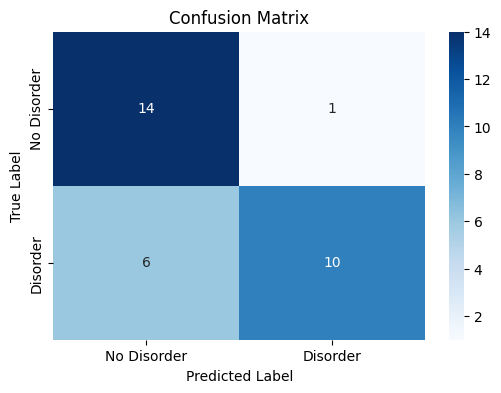

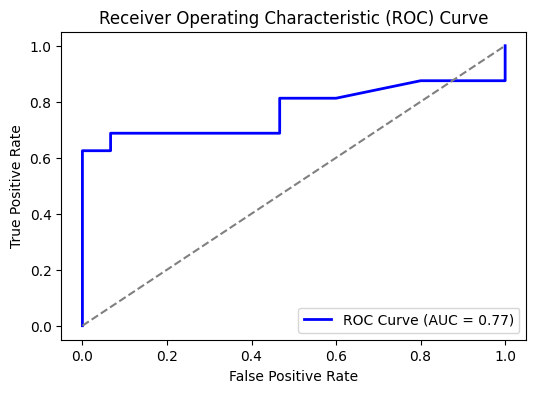

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_prob = best_logreg.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disorder", "Disorder"], yticklabels=["No Disorder", "Disorder"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

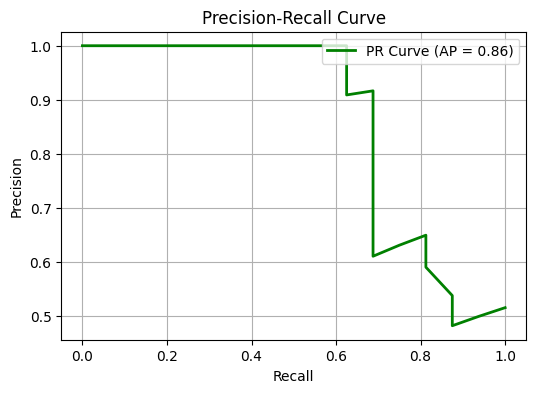

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

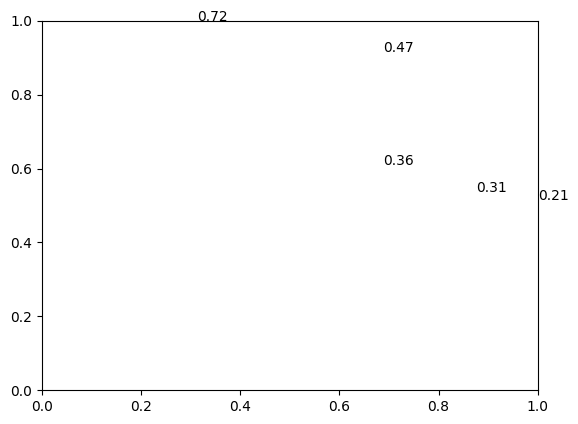

In [ ]:
for i, t in enumerate(thresholds[::5]):
    plt.annotate(f"{t:.2f}", (recall[::5][i], precision[::5][i]))

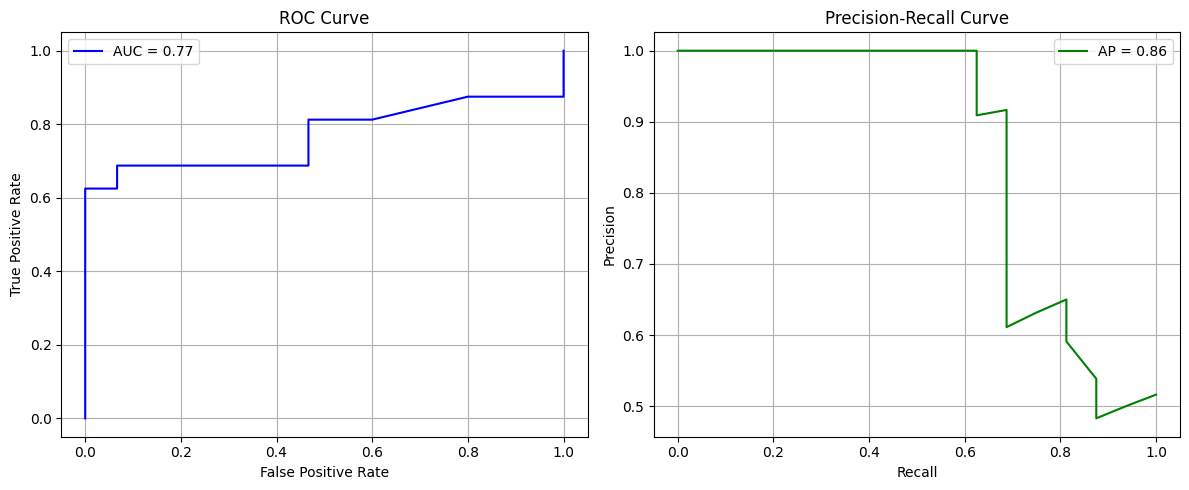

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# ROC
axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()
axs[0].grid(True)
# PR
axs[1].plot(recall, precision, label=f"AP = {avg_precision:.2f}", color='green')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12  3]
 [ 3 13]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.81      0.81      0.81        16

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



In [ ]:
importance = logreg.coef_[0]
for i, col in enumerate(X.columns):
    print(f"{col}: {importance[i]:.4f}")

Age: -0.6828
Gender: -1.1916
Sleep Duration: 1.6064
Quality of Sleep: 0.0973
Physical Activity Level: -0.1419
Stress Level: 0.2248
BMI Category: -0.0019
Systolic_BP: -0.2930
Diastolic_BP: 1.4849
Heart Rate: 1.4257
Daily Steps: 1.3725


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y, cv=5, scoring='average_precision')
print("Cross-validated average precision:", scores.mean())

Cross-validated average precision: 0.8790856457038991


Artifical Neural Networks

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, roc_auc_score
# Try computing AUC, handle missing class error
from sklearn.preprocessing import label_binarize

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the dataset
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")
df = df.dropna()

# Label encode categorical variables
label_encoders = {}
label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])
label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])
label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])

# Split blood pressure into systolic and diastolic
df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df = df.drop(columns=["Blood Pressure"])

# Select features and target
features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
            "Stress Level", "BMI Category", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]

X = df[features].copy()
y = df["Sleep Disorder"]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
y_cat = tf.keras.utils.to_categorical(y, num_classes=3)

# Train/test split (larger test set to help AUC)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, stratify=y, random_state=42)

# Print class distribution in test set
# print("Class distribution in test set:", np.unique(np.argmax(y_test, axis=1), return_counts=True))
print("Full dataset class distribution:", np.unique(y, return_counts=True))

# Build an improved model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Performance metrics
acc = accuracy_score(y_test_labels, y_pred_labels)
prec = precision_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

# Rebuild y_test using full class list
y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = y_pred

# Check if all classes are present in test set
unique_test_classes = np.unique(y_test_labels)
if set([0, 1, 2]).issubset(set(unique_test_classes)):
    y_test_bin = label_binarize(y_test_labels, classes=[0, 1, 2])
    try:
        auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    except ValueError as e:
        print(f"AUC error: {e}")
        auc = np.nan
else:
    print(f"⚠️ Cannot compute AUC: missing classes in test set → found {unique_test_classes}")
    auc = np.nan

# Print results
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoders["Sleep Disorder"].classes_))
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

Full dataset class distribution: (array([0, 1]), array([77, 78]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.2251 - loss: 1.9745 - val_accuracy: 0.0909 - val_loss: 1.3065
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2437 - loss: 1.9510 - val_accuracy: 0.1818 - val_loss: 1.2413
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4211 - loss: 1.3905 - val_accuracy: 0.6364 - val_loss: 1.1796
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4054 - loss: 1.4258 - val_accuracy: 0.7273 - val_loss: 1.1260
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5830 - loss: 1.2091 - val_accuracy: 0.7273 - val_loss: 1.0791
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4895 - loss: 1.2913 - val_accuracy: 0.9091 - val_loss: 1.0392
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6576 - loss: 0.9784 - val_accuracy: 0.9091 - val_loss: 1.0017
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6576 - loss: 0.9865 - val_accuracy: 0.9091 - val_loss

Support Vector Machine

<ipython-input-3-b3a67cdbb18d>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features])



SVM Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.88      0.93      0.90        15
 Sleep Apnea       0.93      0.88      0.90        16

    accuracy                           0.90        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31

Accuracy: 0.90
Precision: 0.90
F1-score: 0.90
AUC: 0.93


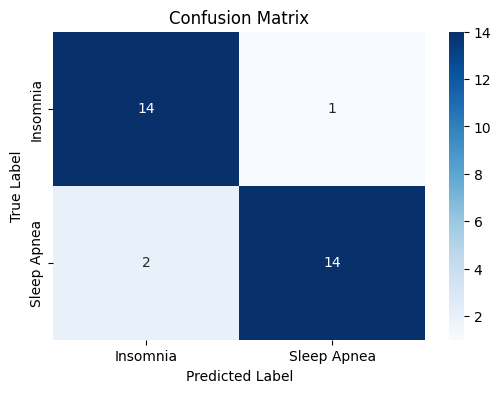

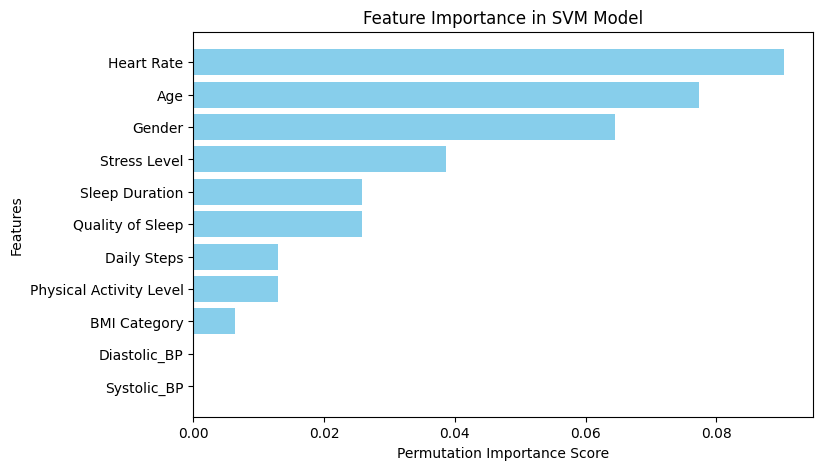

<ipython-input-3-b3a67cdbb18d>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set2")


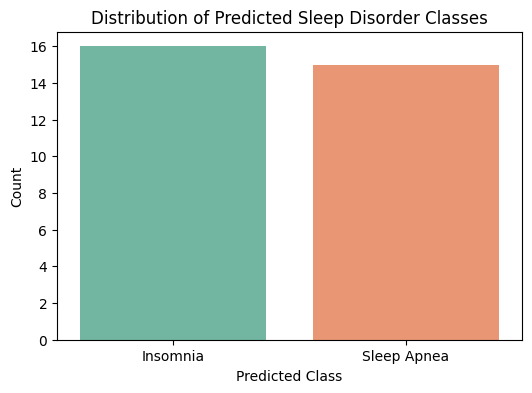

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

# Load and clean data
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")
df = df.dropna()

# Encode categorical columns
label_encoders = {}

label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])

label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])

label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])  # None=0, Insomnia=1, Sleep Apnea=2

# Split blood pressure into systolic and diastolic
df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df = df.drop(columns=["Blood Pressure"])

# Features and target
features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level",
            "BMI Category", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]
X = df[features]
y = df["Sleep Disorder"]

# Normalize features
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=False)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation metrics
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoders["Sleep Disorder"].classes_))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# AUC calculation
if len(np.unique(y_test)) == 2:
    # Binary AUC
    y_score = svm_model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
else:
    # Multiclass AUC
    y_score = svm_model.decision_function(X_test)
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders["Sleep Disorder"].classes_,
            yticklabels=label_encoders["Sleep Disorder"].classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
perm_importance = permutation_importance(svm_model, X_test, y_test, scoring='accuracy', random_state=42)
feature_importance = perm_importance.importances_mean
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in SVM Model")
plt.gca().invert_yaxis()
plt.show()

# Predicted class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred, palette="Set2")
unique_classes = np.sort(np.unique(y_pred))
plt.xticks(ticks=unique_classes, labels=[label_encoders["Sleep Disorder"].classes_[i] for i in unique_classes])
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Predicted Sleep Disorder Classes")
plt.show()

XGBoost and Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")
df = df.dropna()

label_encoders = {}
for col in ["Gender", "BMI Category", "Sleep Disorder"]:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df = df.drop(columns=["Blood Pressure"])

features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
            "Stress Level", "BMI Category", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]

X = df[features].copy()
y = df["Sleep Disorder"]
X = StandardScaler().fit_transform(X)

In [ ]:
print("\n--- Random Forest ---")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro'):.2f}")
print(f"AUC: {roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr'):.2f}")


--- Random Forest ---
Accuracy: 0.87
Precision: 0.87
F1-score: 0.87
AUC: 0.93


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

print("\n--- XGBoost ---")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, f1s, aucs = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))

    # For AUC, binarize the y_test labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    try:
        aucs.append(roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr'))
    except ValueError:
        pass

print(f"Accuracy: {np.mean(accs):.2f}")
print(f"Precision: {np.mean(precs):.2f}")
print(f"F1-score: {np.mean(f1s):.2f}")
print(f"AUC: {np.mean(aucs):.2f}" if aucs else "AUC: undefined")


--- XGBoost ---
Accuracy: 0.85
Precision: 0.86
F1-score: 0.84
AUC: 0.93
